# PSF Extractor
---

#### Overview
PSF extractor walkthrough

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

#### Spicy colormap

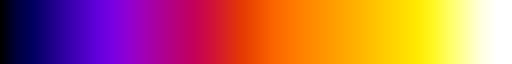

In [3]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

## 1) Find features
---
First step of workflow is to detect features (e.g. fluorescent beads) within a 3D image stack. Features are found using `trackpy.locate`, which takes the expected feature diameters and a minimum mass as input. The expected feature diameters are in pixel dimensions, and ought to be rounded up to the nearest odd integer. The minimum mass is the minimum "integrated brightness" which is used as a parameter to filter out spurious features.

In [4]:
import trackpy
from skimage import exposure
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from psf_extractor import get_stack

### Set parameters
Trackpy takes expected feature diameters in ($z$, $y$, $x$) as input. Requires input diameters to be odd and recommends rounding up.

In [5]:
# Set pixel sizes [nm/px]
psx = 64
psy = psx
psz = 125

# Set expected feature diameters [nm]
dx_nm = 800
dy_nm = dx_nm
dz_nm = 1500

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
diameters = np.ceil([dz, dy, dx]).astype(int) // 2 * 2 + 1
diameters

array([13, 13, 13], dtype=int32)

In [6]:
# Set candidate minimum masses
min_masses = [50, 100, 500, 1000, 2000, 5000]

### Create stack

In [7]:
# Set directory of image stack
file_pattern = '../data/sample_zstack_png_sequence/'
# Load image stack
stack = get_stack(file_pattern)

INFO:root:Creating stack from directory.
INFO:root:Reading image file (1/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0000.png
INFO:root:Reading image file (2/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0001.png
INFO:root:Reading image file (3/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0002.png
INFO:root:Reading image file (4/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0003.png
INFO:root:Reading image file (5/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0004.png
INFO:root:Reading image file (6/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0005.png
INFO:root:Reading image file 

### Maximum intensity projection in `z`

In [8]:
# Calculate the maximum projection image of the image stack
mip = np.max(stack, axis=0)

# Normalize the maximum intensity projection
mipn = exposure.rescale_intensity(mip)
mipn *= 255./mipn.max()

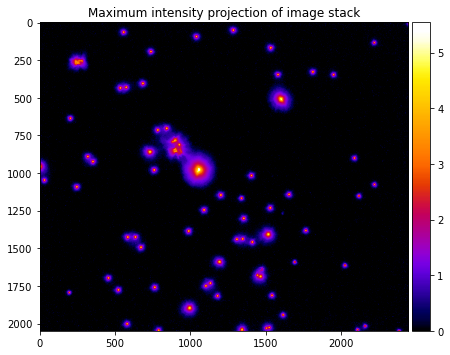

In [9]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast, avoid /b0 error
mpn_log = np.log(mipn,
                 out=np.zeros_like(mipn),
                 where=mipn!=0)
im = ax.imshow(mpn_log, cmap=fire)
ax.set_title('Maximum intensity projection of image stack')
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Find features
The appropriate minimum will vary from dataset to dataset. Here a number of minimum masses are experimented with so that the user can select the value they find appropriate.

  0%|          | 0/6 [00:00<?, ?it/s]

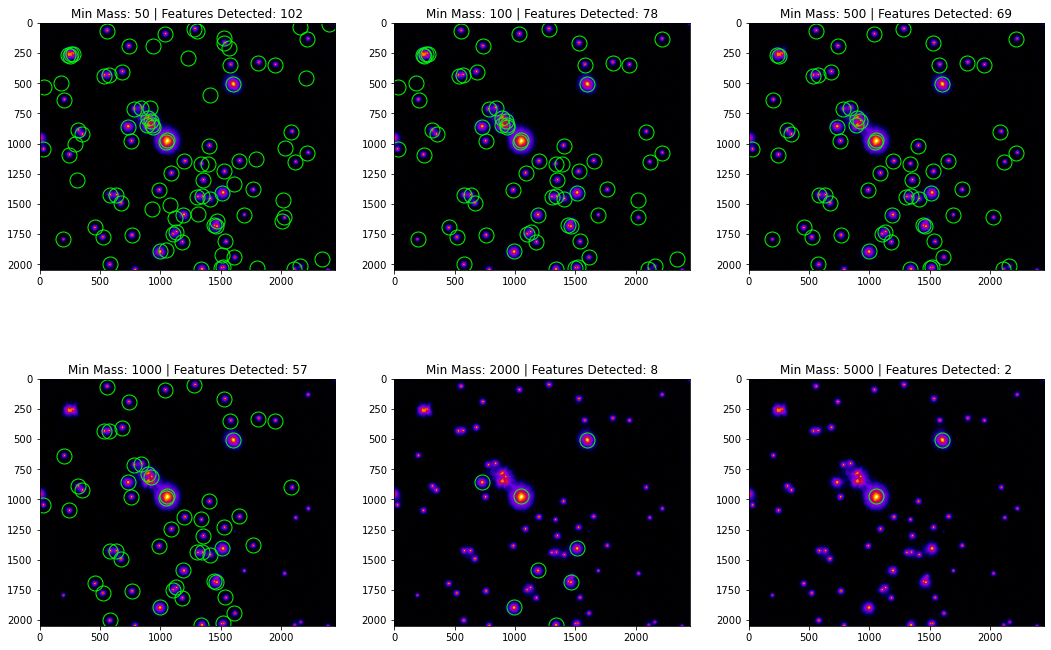

In [10]:
# Set up figure
ncols = 3
nrows = int(np.ceil(len(min_masses) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

# Loop through candidate minimum masses
for i, min_mass in tqdm(enumerate(min_masses),
                        total=len(min_masses)):

    # Locate features
    df_features = trackpy.locate(mipn,
                                 diameter=diameters[1:],  # (y, x) only
                                 minmass=min_mass).reset_index(drop=True)

    # Plot max projection image
    ax = axes.flat[i]
    # Take log to enhance contrast (avoiding /b0 error)
    mpn_log = np.log(mipn,
                     out=np.zeros_like(mipn),
                     where=mipn!=0)
    ax.imshow(mpn_log, cmap=fire)
    # Plot detected features
    ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
            marker='o', ms=15, mfc='none', mew=1)
    title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
    ax.set_title(title)

#### Find features with chosen minimum mass

In [11]:
# Update value
min_mass = 750

# Locate features
df_features = trackpy.locate(mipn,
                             diameter=diameters[1:],
                             minmass=min_mass).reset_index(drop=True)
# Display a sample of located features
df_features.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


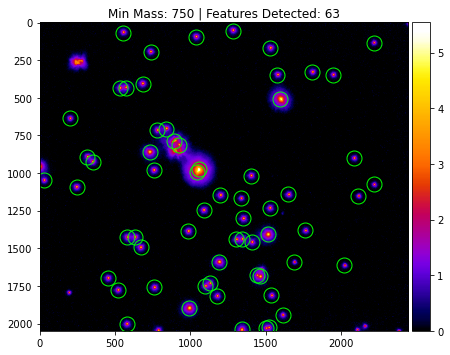

In [12]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast (avoiding /b0 error)
mpn_log = np.log(mipn,
                 out=np.zeros_like(mipn),
                 where=mipn!=0)
im = ax.imshow(mpn_log, cmap=fire)
# Plot detected features
ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
        marker='o', ms=15, mfc='none', mew=1)
title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
ax.set_title(title)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Filter out overlapping features

In [13]:
from itertools import combinations
from psf_extractor import bboxes_overlap

In [14]:
# Set bounding box dimensions [μm]
dx_um = 5
dy_um = dx_um

# Convert bounding box dimensions [μm --> px]
dx = dx_um / psx * 1e3
dy = dy_um / psy * 1e3

dx, dy

(78.125, 78.125)

In [15]:
# Create bounding box for each feature based 
# on the dimensions of the subvolume
df_bboxes = df_features.loc[:, ['x', 'y']]

df_bboxes['x_min'] = df_features['x'] - dx/2
df_bboxes['y_min'] = df_features['y'] - dy/2
df_bboxes['x_max'] = df_features['x'] + dx/2
df_bboxes['y_max'] = df_features['y'] + dy/2

df_bboxes.head()

,x,y,x_min,y_min,x_max,y_max
0,1282.117447,53.262390,1243.054947,14.199890,1321.179947,92.324890
1,555.069618,66.516080,516.007118,27.453580,594.132118,105.578580
2,1037.309400,95.478668,998.246900,56.416168,1076.371900,134.541168
3,2216.655063,136.548734,2177.592563,97.486234,2255.717563,175.611234
4,1530.268528,170.191908,1491.206028,131.129408,1569.331028,209.254408


In [16]:
# Collect overlapping features
overlapping_features = []
# Iterate through every (unique) pair of bounding boxes
ij = list(combinations(df_bboxes.index, 2))
for i, j in tqdm(ij, total=len(ij)):

    # Create bounding boxes for each pair of features
    bbox_i = df_bboxes.loc[i, ['x_min', 'y_min', 'x_max', 'y_max']].values
    bbox_j = df_bboxes.loc[j, ['x_min', 'y_min', 'x_max', 'y_max']].values

    # Check for overlap
    if bboxes_overlap(bbox_i, bbox_j):
        overlapping_features.append(i)
        overlapping_features.append(j)

# Remaining features
df_features = df_features.drop(index=overlapping_features)\
                         .reset_index(drop=True)
df_features.head()

  0%|          | 0/1953 [00:00<?, ?it/s]

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


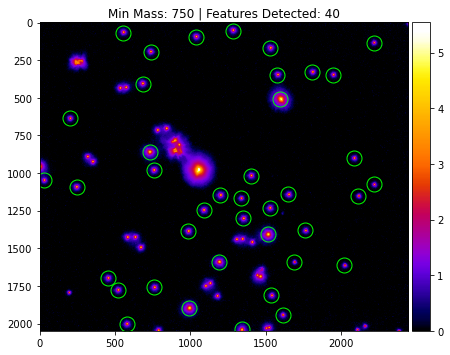

In [17]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast, avoid /b0 error
mpn_log = np.log(mipn,
                 out=np.zeros_like(mipn),
                 where=mipn!=0)
im = ax.imshow(mpn_log, cmap=fire)
# Plot detected features
ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
        marker='o', ms=15, mfc='none', mew=1)
title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
ax.set_title(title)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Filter based on mass

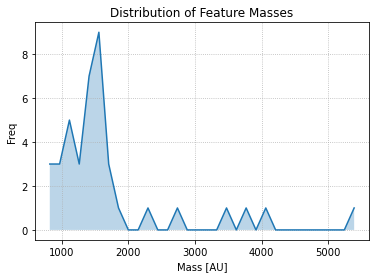

In [18]:
hist, bins = np.histogram(df_features['mass'], bins=32)
bins = (bins[1:] + bins[:-1]) / 2

fig, ax = plt.subplots()
ax.plot(bins, hist)
ax.fill_between(bins, 0, hist, alpha=0.3)
ax.grid(ls=':')
ax.set_xlabel('Mass [AU]')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Feature Masses');

In [19]:
# Not sure what's going on here

In [20]:
#     #Select on mass
#     lenmass = len(features_filt)
#     if lenmass > 12: lenmass /= 2
#     features_filt = features_filt.sort_values('mass').head(n=int(lenmass)).reset_index()

## 2) Localize features
---
The idea is to overlay all of the individual PSFs in the image stack to derive an average PSF. In order to do this, the individual PSF positions must be localized with subpixel accuracy in $x$, $y$, and $z$. This is accomplished by first fitting a 2D Gaussian to the maximum intensity projection of each PSF (to get the $x$, $y$ position), and then by fitting a 1D Gaussian to the resulting line profile through the center of the PSF (to get the $z$ position).

#### Process
1. The PSF is extracted from each (previously detected) feature
1. Outlier PSFs are filtered out
1. Localization via Gaussian fits

### Extract PSFs

In [21]:
from psf_extractor import extract_psfs

In [22]:
# Set dimensions of subvolume [μm]
wx_um = 5
wy_um = wx_um
wz_um = 5

# Convert dimensions of subvolume [μm --> px]
wx = (wx_um / psx * 1e3)
wy = (wy_um / psy * 1e3)
wz = (wz_um / psz * 1e3)

# Compile dimensions (z, y, x)
shape_psf = [wz, wy, wx]
shape_psf

[40.0, 78.125, 78.125]

#### Plot maximum intensity projections of extracted PSFs

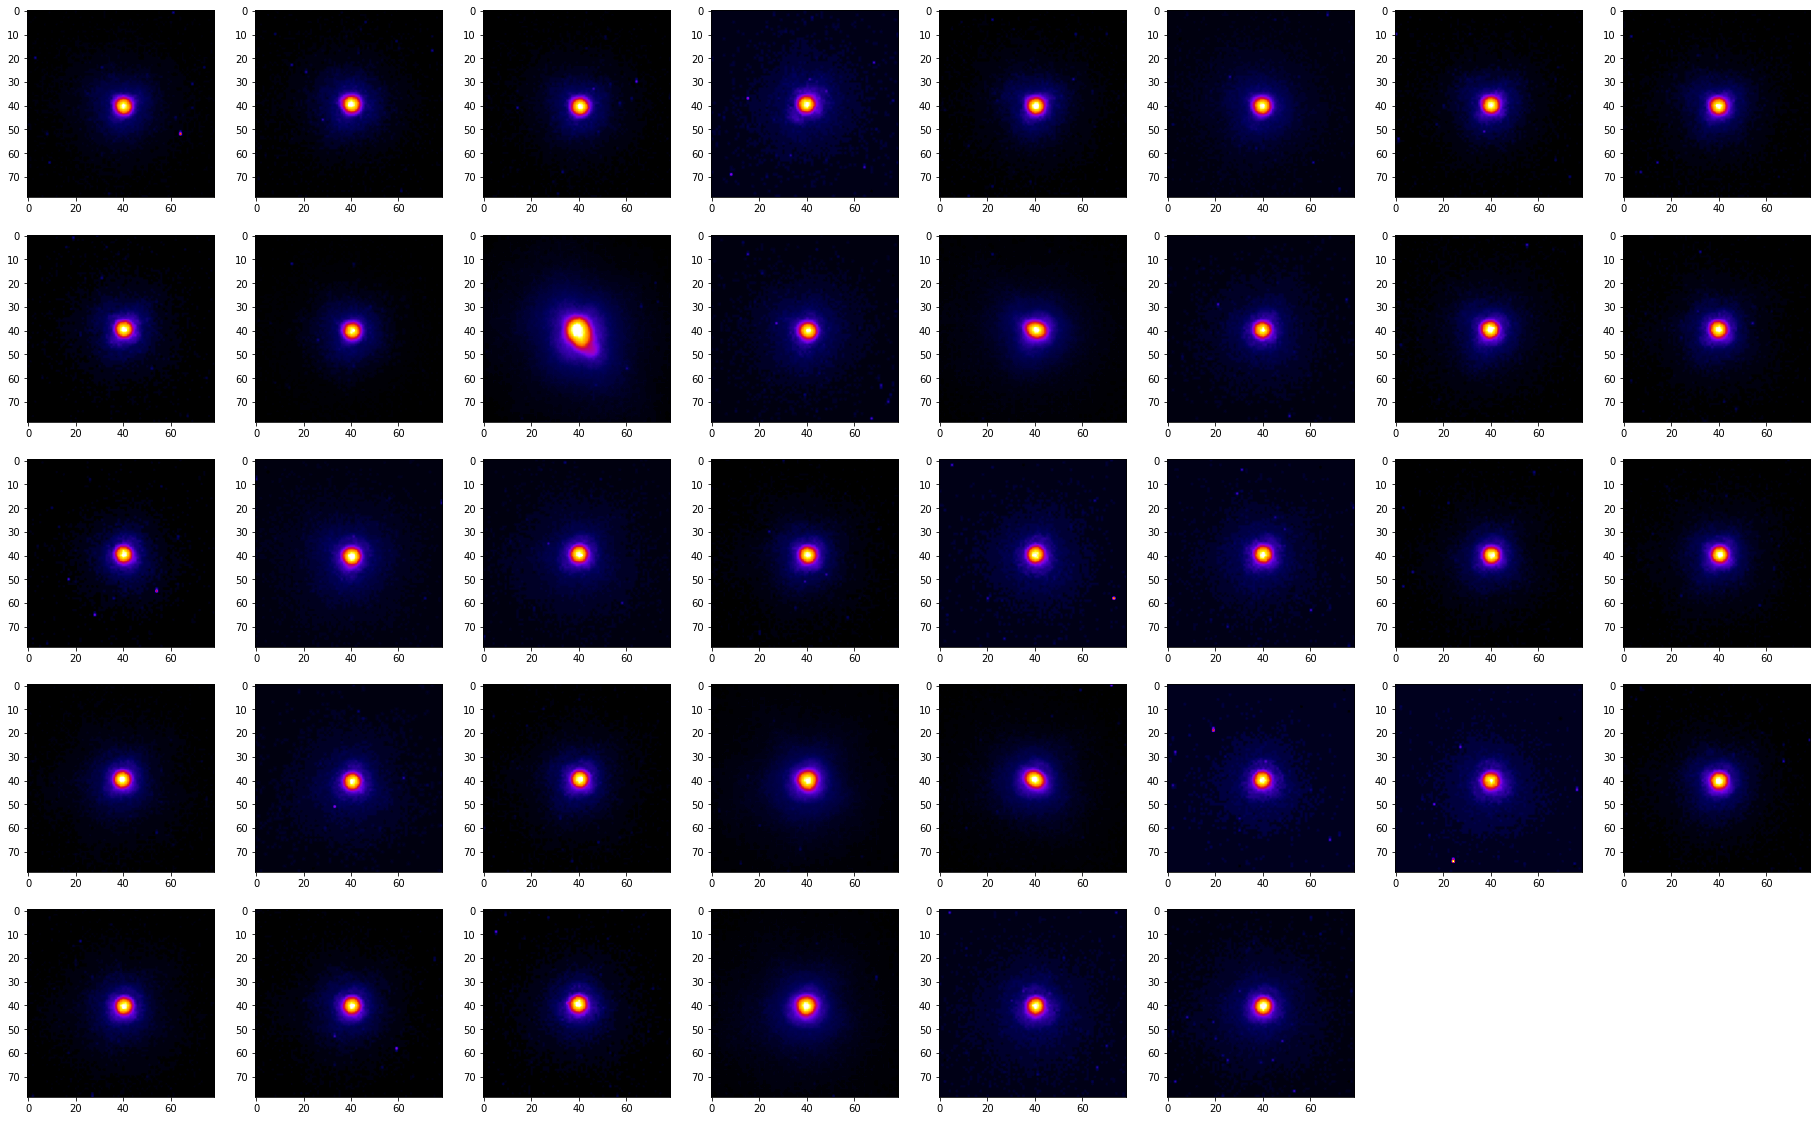

In [23]:
# Extract PSFs
psfs, df_features_ = extract_psfs(stack, df_features, shape_psf)

# Create figure
ncols = 8
nrows = int(np.ceil(len(psfs) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
for i, psf in enumerate(psfs):
    ax = axes.flat[i]
    mip = np.max(psf, axis=0)
    ax.imshow(mip, cmap=fire)
# Remove empty subplots
[fig.delaxes(axes.flat[-i-1]) for i in range(ncols*nrows - len(psfs))];

### Filter out strange PSFs
Use the Pearson correlation coefficient to filter out oultier PSFs. Each PSF is compared to every other PSF. Outlier criteria is based on a PSF having a PCC that frequently falls outside the acceptable range ($\mu_{PCC} \,\pm\, 3\sigma_{PCC}$).

Why isn't once enough? Because it takes 2 PSFs to generate a wild PCC value. One of these PSFs may be totally fine, but the only way to tell a typical PSF from an outlier is by checking the number of occurences each PSF falls in the outlier range.

How many times is frequently? A bit arbitrary, but $3\times$ the average number of occurences seems to work empirically.

In [24]:
from itertools import combinations
from scipy.stats import pearsonr

In [25]:
# Collect PCCs
pccs = []
# Iterate through every (unique) pair of PSFs
ij = list(combinations(range(len(psfs)), 2))
for i, j in tqdm(ij, total=len(ij)):

    # Get pairs of PSFs
    mip_i = np.max(psfs[i], axis=0)
    mip_j = np.max(psfs[j], axis=0)
    # Calculate PCC of maximum intensity projections
    pcc, _ = pearsonr(mip_i.ravel(),
                      mip_j.ravel())
    pccs.append(pcc)

# Convert to array
pccs = np.array(pccs)

  0%|          | 0/703 [00:00<?, ?it/s]

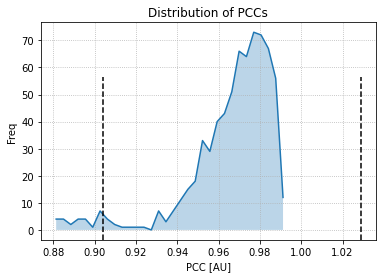

In [26]:
# Get distribution
hist, bins = np.histogram(pccs, bins=32)
bins = (bins[1:] + bins[:-1]) / 2

# Outlier criteria
pcc_min = pccs.mean() - 3*pccs.std()
pcc_max = pccs.mean() + 3*pccs.std()

# Plot distribution
fig, ax = plt.subplots()
ax.plot(bins, hist)
ax.fill_between(bins, 0, hist, alpha=0.3)
# Plot outlier range
ax.axvline(pcc_min, ymax=0.75, color='k', ls='--')
ax.axvline(pcc_max, ymax=0.75, color='k', ls='--')
# Aesthetics
ax.grid(ls=':')
ax.set_xlabel('PCC [AU]')
ax.set_ylabel('Freq')
ax.set_title('Distribution of PCCs');

In [27]:
# Get indices of candidate outliers
suspects_i = np.argwhere((pccs < pcc_min) |\
                         (pccs > pcc_max))
# Convert to indices of PSF pairs
suspects_ij = np.array(ij)[suspects_i[:, 0]]

# Determine frequency of out lying (?)
i, counts = np.unique(suspects_ij, return_counts=True)
outliers = i[counts > 3*counts.mean()]
outliers

array([10])

In [28]:
# Remove outliers
df_features_ = df_features_.drop(outliers)
df_features_.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


### Least squares fitting
* 2D Gaussian fit for $x$, $y$ localization 
* 1D Gaussian fit for $z$ localization
  * Might it be better to sum/integrate in x, y?

In [29]:
from scipy.optimize import curve_fit

from psf_extractor import (gaussian_1D, fit_gaussian_1D,
                           gaussian_2D, fit_gaussian_2D)

In [30]:
# Re-extract PSFs based on updated feature set
psfs, df_features = extract_psfs(stack, df_features_, shape_psf)

In [31]:
# Initialize localization DataFrame
columns = ['x0', 'y0', 'z0', 'sigma_x', 'sigma_y', 'sigma_z']
df_loc = pd.DataFrame(columns=columns)

# Loop through PSFs
for i, psf in enumerate(psfs):

    # 2D Fit
    # ------
    # Take maximum intensity projection
    mip = np.max(psf, axis=0)
    x0, y0, sigma_x, sigma_y, A, B = fit_gaussian_2D(mip)

    # 1D Fit
    # ------
    # Take z slice through x0, y0
    z_slice = psf[:,int(x0),int(y0)]
    z0, sigma_z, A, B = fit_gaussian_1D(z_slice)

    # Populate DataFrame
    df_loc.loc[i, columns] = [x0, y0, z0, sigma_x, sigma_y, sigma_z]

# Preview DataFrame
df_loc.head()

,x0,y0,z0,sigma_x,sigma_y,sigma_z
0,40.115621,40.274541,15.345056,2.593391,2.575073,1.354436
1,40.058154,39.522492,15.439934,2.651204,2.555141,1.3661
2,40.325301,40.489732,15.375329,2.619622,2.541125,1.327178
3,39.715005,39.540575,15.009761,2.694607,2.598507,1.289686
4,40.282196,40.211879,15.135672,2.652254,2.593331,1.317402


#### Plot localization data

In [32]:
from psf_extractor import plot_psf_localizations

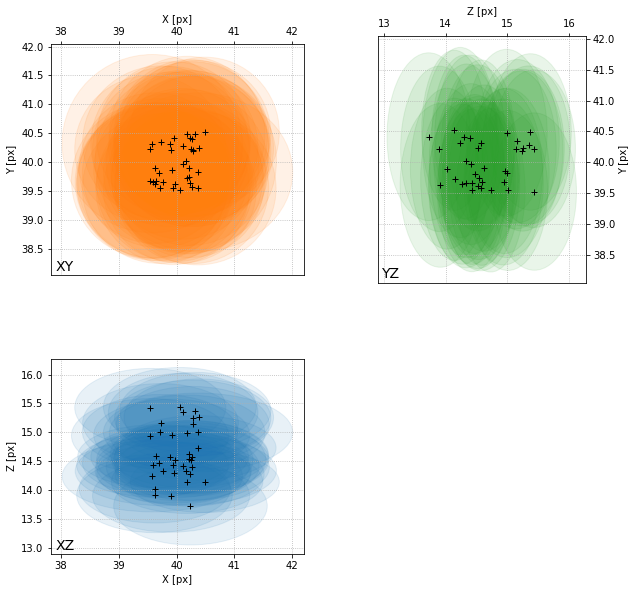

In [33]:
plot_psf_localizations(df_loc)

## Characterize PSF
---

#### Quick upsampling demo

In [34]:
from skimage.transform import resize

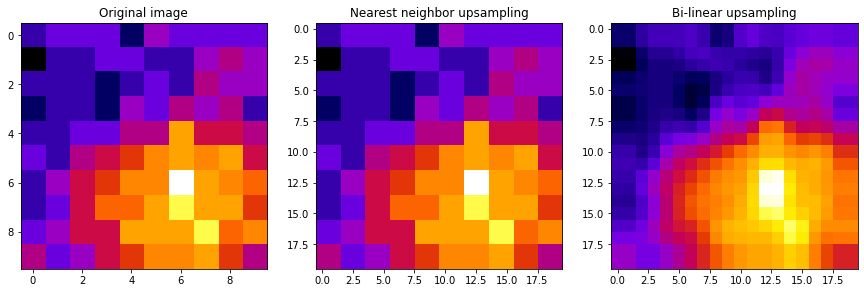

In [35]:
# Crop the central spot from a random psf
w = 10
i = np.random.randint(len(psfs))
Nz, Ny, Nx = psfs[i].shape
image = psfs[i][Nz//2,
                Ny//2-w//2: Ny//2+w//2,
                Nx//2-w//2: Nx//2+w//2].copy()

# Upsample with nearest-neighbor interpolation
image_k0 = resize(image, output_shape=(2*w, 2*w), order=0)
image_k1 = resize(image, output_shape=(2*w, 2*w), order=1)

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(image, cmap=fire)
axes[1].imshow(image_k0, cmap=fire)
axes[2].imshow(image_k1, cmap=fire)
# Aesthetics
axes[0].set_title('Original image')
axes[1].set_title('Nearest neighbor upsampling')
axes[2].set_title('Bi-linear upsampling');

### Upsample and align PSFs

In [ ]:
def align_psfs():
    """"""

In [38]:
# def upsample_psfs(psfs, upsample_factor=4, output_shape=None):
#     """Upsample PSFs with nearest-neighbor interpolation

#     Parameters
#     ----------
#     psfs : array-like
#         List (or numpy array) of PSFs
#     upsample_factor : scalar
#         Upsample factor
#     output_shape : array-like, 3-tuple
#         Shape of upsampled PSFs (K, M, N)

#     Returns
#     -------
#     psfs_up : array-like
#         4D stack of all the upsample PSFs

#     Notes
#     -----
#     * Converts to 32bit float array to save memory
#     """
#     # If output_shape is provided, upsample with skimage.transform.resize
#     if output_shape is not None:
#         psfs_up = []
#         for psf in psfs:
#             psf_up = resize(psf.astype(np.float32),
#                             output_shape=output_shape,
#                             order=0)
#             psfs_up.append(psf_up)

#     # Use np.repeat by default (which is faster but less flexible)
#     else:
#         usf = upsample_factor  # alias for upsample factor
#         psfs_up = []
#         psfs_up = [psf.astype(np.float32)\
#                       .repeat(usf, axis=0)\
#                       .repeat(usf, axis=1)\
#                       .repeat(usf, axis=2) for psf in psfs]
#     return np.array(psfs_up)

In [39]:
# psfs_up = upsample_psfs(psfs, upsample_factor=4)

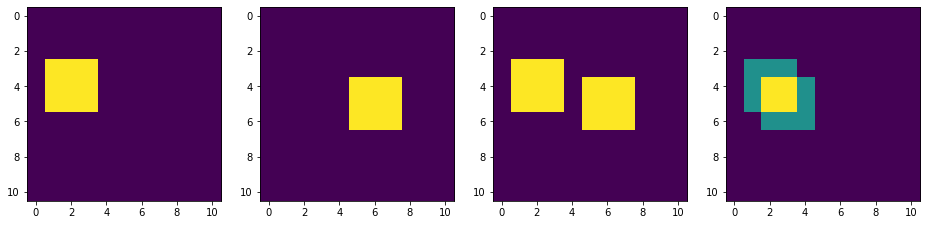

In [106]:
a = np.zeros((11, 11))
a[3:6, 1:4] = 1

b = np.zeros_like(a)
b[4:7, 5:8] = 1

c = a + b

# Shift in (y, x)
d = a + np.roll(b, shift=(0, -3), axis=(0, 1))

fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
axes[0].imshow(a)
axes[1].imshow(b)
axes[2].imshow(c)
axes[3].imshow(d)

In [ ]:
# Collect volumes for PSF
psf_volumes = []
for i, row in df_features_.iterrows():
    psf_volumes.append(psfs[i])

In [ ]:
# Average the psf subvolumes
psf = np.mean(psf_volumes, axis=0)
psf.shape

In [ ]:
Nz, Ny, Nx = psf.shape
Nmin = np.min([Nz, Ny, Nx])
Nmin

In [ ]:
# Determine smallest dimension of total psf
Nz, Ny, Nx = psf.shape
Nmin = np.min([Nz, Ny, Nx])

# Crop total psf to a cube defined by the smallest dimension
z1, z2 = (Nz-Nmin)//2, Nz - ((Nz-Nmin)//2) - Nz % 2
y1, y2 = (Ny-Nmin)//2, Ny - ((Ny-Nmin)//2) - Ny % 2
x1, x2 = (Nx-Nmin)//2, Nx - ((Nx-Nmin)//2) - Nx % 2
psf_cube = psf[z1:z2, y1:y2, x1:x2]

psf_cube.shape

In [ ]:
psf = psf_cube.copy()

In [ ]:
# Create figure and axes
fig = plt.figure(figsize=(11, 11))
gs = fig.add_gridspec(6, 6)
ax_xy = fig.add_subplot(gs[:3,:3])
ax_yz = fig.add_subplot(gs[:3,3:])
ax_xz = fig.add_subplot(gs[3:,:3])
ax_z = fig.add_subplot(gs[-3,3:])
ax_y = fig.add_subplot(gs[-2,3:])
ax_x = fig.add_subplot(gs[-1,3:])

# PSF dimensions
Nz, Ny, Nx = psf.shape
# PSF volume
dz, dy, dx = psz*Nz, psy*Ny, psx*Nx
# PSF center coords
z0, y0, x0 = Nz//2, Ny//2, Nx//2

# Plot 2D PSFs (slices)
ax_xy.imshow(psf[z0,:,:], cmap=fire)
ax_yz.imshow(psf[:,y0,:], cmap=fire)
ax_xz.imshow(psf[:,:,x0], cmap=fire)
# 1D PSFs (slices)
prof_z = psf[:,y0,x0]
prof_y = psf[z0,:,x0]
prof_x = psf[z0,y0,:]
# Plot 1D PSFs
plot_kwargs = {'ms': 5, 'marker': 'o', 'ls': '', 'alpha': 0.75}
ax_z.plot(prof_z, c='C1', label='Z', **plot_kwargs)
ax_y.plot(prof_y, c='C0', label='Y', **plot_kwargs)
ax_x.plot(prof_x, c='C2', label='X', **plot_kwargs)
# Plot 1D PSF fits
u = np.linspace(0, Nz, Ny*Nx)
popt = fit_gaussian_1D(prof_z)
ax_z.plot(u, gaussian_1D(u, *popt))
popt = fit_gaussian_1D(prof_y)
popt = fit_gaussian_1D(prof_x)

# Aesthetics
[ax.legend() for ax in [ax_z, ax_y, ax_x]]
[ax.grid(ls=':') for ax in [ax_z, ax_y, ax_x]]
plt.subplots_adjust(hspace=0.5, wspace=0.5)